In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt

In [4]:
export_base = '191009_ratti_cancer_genes_decades'

In [5]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from access_biology_data import meta, gwas_studies, relations
from access_literature_data import medline, wos
from access_science_shared import standardizer

src_dir = '/Users/tstoeger/Projects/recit/src/'
sys.path[0] = src_dir

import studies
import fullfill
import recit_tools as ret

import nar190730

from scipy.stats import wilcoxon

In [6]:
save_images = False
taxon_id = 9606

In [7]:
usefull_stats = nar190730.get_multiple_useful()

In [8]:
fame_per_gene_per_year = usefull_stats['fame_per_gene_per_year']

In [9]:
from access_literature_data import medline

In [10]:
g2p = medline.gene2pubmed(taxon_id='all', paper_kind='research').drop_duplicates()

In [11]:
g2p = pd.merge(
    g2p, 
    (1 / g2p['pubmed_id'].value_counts()).to_frame('attention').rename_axis('pubmed_id').reset_index())

In [12]:
years = medline.select_medline_records(
        columns_sql='''
            medline.pubmed_id,
            medline.pubdate_year''',
        taxon_id=None,
        kind='research')

In [13]:
literature = pd.merge(g2p, years)
literature = literature[literature['pubdate_year'].isin(range(1980, 2016))]
literature = literature[literature['taxon_ncbi']==taxon_id]
literature = literature.drop('taxon_ncbi', 1)

In [14]:
total_annual_literature = literature[
    ['pubdate_year', 'attention']].groupby('pubdate_year').agg(sum).rename(
    columns={'attention': 'annual_attention'}
).reset_index()

fame_per_gene_per_year = literature[
    ['gene_ncbi', 'pubdate_year', 'attention']
].groupby(['gene_ncbi', 'pubdate_year']).agg(sum).reset_index()

fame_per_gene_per_year = pd.merge(
    fame_per_gene_per_year,
    total_annual_literature
)

fame_per_gene_per_year.loc[:, 'attention_share'] = fame_per_gene_per_year[
    'attention'] / fame_per_gene_per_year['annual_attention']

In [15]:
p = '/Users/tstoeger/Dropbox/ratti/data/network_of_cancer_genes/ncg6_0/cancergenes_list.txt'
df_ncg = pd.read_csv(p, '\t')

In [16]:
all_gene_info = meta.gene_info(9606, ['gene_ncbi', 'symbol_ncbi'])

In [17]:
all_gene_info = all_gene_info.drop_duplicates('symbol_ncbi', keep=False)   # NCG uses symbols that can ambiguous

In [18]:
cancer_genes = all_gene_info[all_gene_info['symbol_ncbi'].isin(df_ncg['711_Known_Cancer_Genes'])]

In [19]:
mega = pd.merge(
    cancer_genes,
    fame_per_gene_per_year[['pubdate_year', 'gene_ncbi', 'attention', 'attention_share']]
)

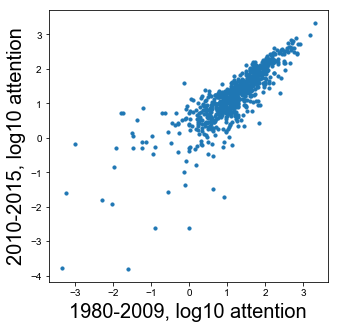

In [20]:
m = mega.copy()
m.loc[:, 'before'] = m['pubdate_year'] < 2010
m = m[['before', 'attention', 'symbol_ncbi']
        ].groupby(['before', 'symbol_ncbi']).agg(
    sum).reset_index()

h = m.pivot(index='symbol_ncbi', columns='before', values='attention')
h.columns = [str(int(x)) for x in h.columns]
h = h.rename(columns={'0': 'until 2009', '1': '2010-2015'})

plt.figure(figsize=(5, 5))

plt.scatter(
    np.log10(h.loc[:, 'until 2009']), 
    np.log10(h.loc[:, '2010-2015']), s=10)

plt.xlabel('1980-2009, log10 attention', fontsize=20)
plt.ylabel('2010-2015, log10 attention', fontsize=20)

if save_images:
    ret.export_image('{}/attention_scatter.pdf'.format(export_base))

In [21]:
h[
    (h['2010-2015']>10) &
    (h['until 2009']<1)
]

,until 2009,2010-2015
symbol_ncbi,,
FES,0.750083,37.913332


In [22]:
if save_images:
    ret.export_full_frame('{}/inspect_paper_format.xlsx'.format(export_base), h, save_index=False)

In [60]:
m = mega.copy()

In [61]:
m['decade'] = m['pubdate_year'].apply(lambda x: np.floor(x/10)*10)

In [62]:
# mega = pd.merge(
#     cancer_genes,
#     fame_per_gene_per_year[['pubdate_year', 'gene_ncbi', 'attention_share']]
# )

# mega = mega[mega['pubdate_year']<2016]

In [63]:
m = m[['gene_ncbi', 'symbol_ncbi', 'decade', 'attention_share']].groupby(
    ['gene_ncbi', 'symbol_ncbi', 'decade']
).agg(np.median).reset_index()

In [64]:
g = m.pivot(index='symbol_ncbi', columns='decade', values='attention_share')

In [65]:
g = g.loc[:, [1980, 1990, 2000, 2010]].fillna(0)

In [66]:
def z_score(x):
    x = (x-np.mean(x)) / np.std(x)
    return x

In [67]:
z = g.apply(z_score, 1)

In [68]:
m = g.apply(lambda x: x/np.max(x), 1)

In [69]:
g.loc[:, 'max'] = g.max(1)
g.loc[:, 'highest'] = 1980


In [70]:


for j in [1980, 1990, 2000, 2010]:
    f = g.loc[:, j] == g.loc[:, 'max']
    g.loc[f, 'highest'] = j

In [71]:
g.loc[:, 'before'] = g.loc[:, 1980] + g.loc[:, 1990] + g.loc[:, 2000]

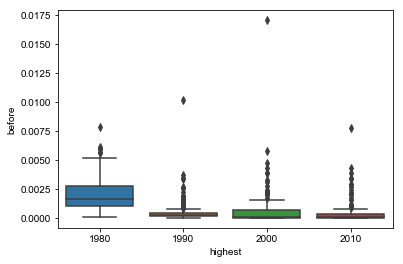

In [72]:
sns.boxplot(x='highest', y='before', data=g)

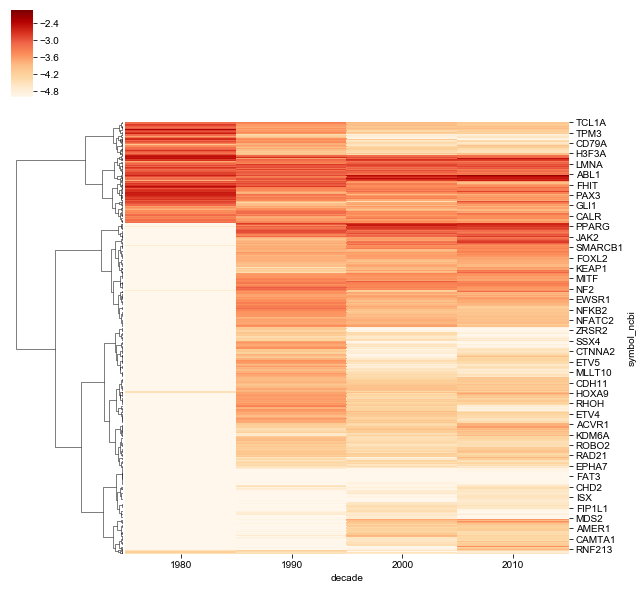

In [87]:
sns.clustermap(
    g[[1980, 1990, 2000, 2010]].apply(lambda x: np.log10(x+0.00001)), 
    col_cluster=False,
    cmap='OrRd',
    method='ward')



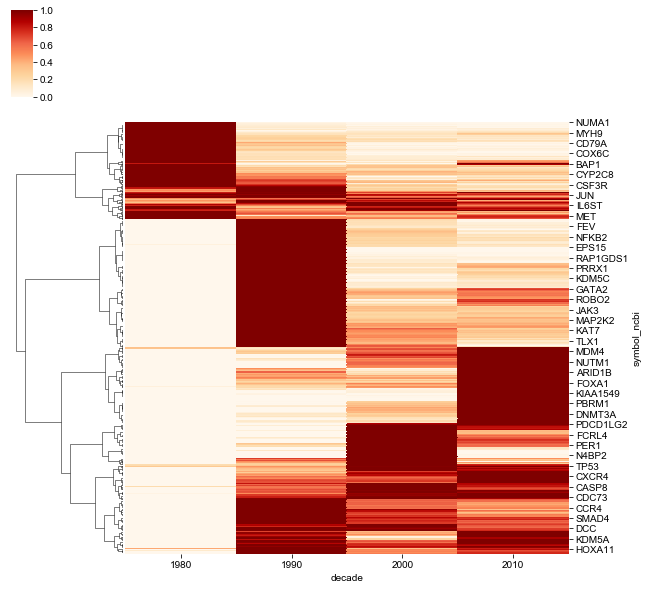

In [73]:
sns.clustermap(
    m, 
    col_cluster=False, 
    vmin=0, 
    vmax=1, 
    cmap='OrRd',
    method='ward')


if save_images:
    ret.export_image('{}/attention_clustermap_max_fraction_of_annual.pdf'.format(export_base))

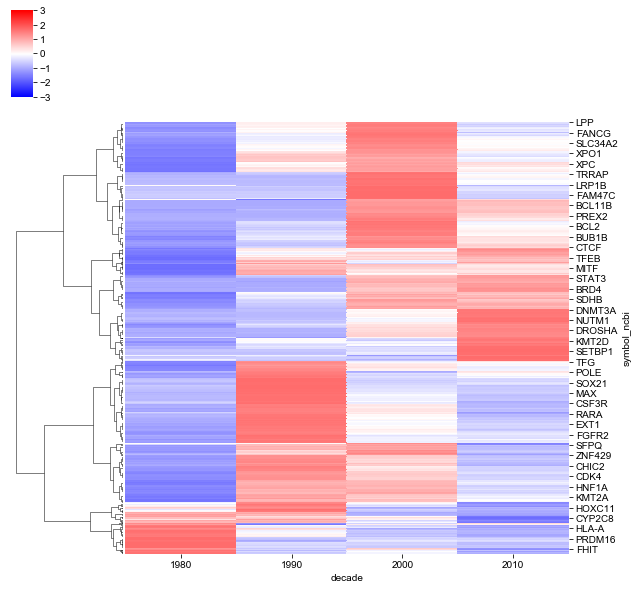

In [58]:
sns.clustermap(
    z, 
    col_cluster=False, 
    vmin=-3, 
    vmax=3, 
    cmap='bwr',
    method='ward')

if save_images:
    ret.export_image('{}/attention_clustermap_zscored_fraction_of_annual.pdf'.format(export_base))